In [1]:
# finance datareader가 설치 안되어 있을시 실행
# !pip install finance-datareader

In [2]:
import os 
from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import FinanceDataReader as fdr

## 시가 총액과 데이터 가져오기

In [4]:
# 처음 실행시만 한번 돌려보기
# !git clone "https://github.com/FinanceData/marcap.git" marcap

Cloning into 'marcap'...
Updating files:  64% (24/37)
Updating files:  67% (25/37)
Updating files:  70% (26/37)
Updating files:  72% (27/37)
Updating files:  75% (28/37)
Updating files:  78% (29/37)
Updating files:  81% (30/37)
Updating files:  83% (31/37)
Updating files:  86% (32/37)
Updating files:  89% (33/37)
Updating files:  91% (34/37)
Updating files:  94% (35/37)
Updating files:  97% (36/37)
Updating files: 100% (37/37)
Updating files: 100% (37/37), done.


In [4]:
idx = pd.IndexSlice

In [5]:
data_path = Path('marcap', 'data')

In [6]:
file_list = os.listdir(data_path)

In [7]:
data_list = []
for file in file_list:
    file_path = data_path / file 
    data = pd.read_csv(file_path, dtype={'Code':str}, parse_dates=['Date'])
    data_list.append(data) 

C:\Users\PC\anaconda3\envs\ml4t_orginal\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
data = pd.concat(data_list)

In [9]:
# KOSPI 종목만 출력
kospi_data = data[data.Market == 'KOSPI']
kospi_data.rename(columns=str.lower, inplace=True)

kospi_data = kospi_data[['code','close','open', 'high', 'low', 'volume', 'amount', 'marcap','date', 'stocks']]
kospi_data.rename(columns={'code': 'ticker'}, inplace=True)

C:\Users\PC\anaconda3\envs\ml4t_orginal\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [10]:
kospi_data

,ticker,close,open,high,low,volume,amount,marcap,date,stocks
0,015760,27400.0,27600.0,27800.0,27400.0,118190.0,3.255694e+09,1.687268e+13,1995-05-02,615791215
1,005930,119500.0,121000.0,121000.0,118500.0,139560.0,1.667674e+10,6.497053e+12,1995-05-02,54368645
2,005490,65500.0,65800.0,66200.0,65400.0,65970.0,4.334472e+09,6.150569e+12,1995-05-02,93901810
3,000200,9800.0,9500.0,9840.0,9500.0,288380.0,2.805134e+09,3.500639e+12,1995-05-02,357208059
4,002610,31700.0,32000.0,32000.0,31700.0,171460.0,5.452050e+09,2.521027e+12,1995-05-02,79527666
...,...,...,...,...,...,...,...,...,...,...
215875,00781K,9340.0,9470.0,9750.0,9300.0,23910.0,2.252896e+08,7.319749e+09,2021-05-13,783699
215881,009275,75400.0,54200.0,75400.0,54200.0,36543.0,2.554918e+09,6.841796e+09,2021-05-13,90740
215885,002785,7370.0,7300.0,7600.0,7300.0,68308.0,5.174193e+08,6.317697e+09,2021-05-13,857218
215890,000547,33650.0,35000.0,36150.0,33550.0,14229.0,4.910638e+08,5.168640e+09,2021-05-13,153600


In [11]:
kospi_data = kospi_data.groupby(['date', 'ticker']).last()

## ETF, 우선주 제외한 KOSPI 종목 데이터 가져오기

In [12]:
kospi = fdr.StockListing('Kospi')

In [13]:
kospi.dropna(subset=['Sector'], inplace=True)

In [14]:
ticker = kospi.Symbol

In [15]:
# 우선주, ETF 제외하고 남은 종목들 추출
# 이 테스크는 시간이 오래걸립니다.
kospi_data = kospi_data.loc[idx[:, ticker],:]

In [16]:
kospi_data = kospi_data.reorder_levels(['date','ticker']).sort_index()

## ETF, 우선주가 제외돼서 시가총액 순위를 다시 구해줘야 된다.

In [17]:
marcap_data = kospi_data['marcap'].to_frame()

In [18]:
marcap_data = marcap_data.unstack('date')

In [19]:
rank_data = marcap_data.rank(ascending=False)

In [20]:
rank_data.rename(columns={'marcap':'rank'}, inplace=True)

In [21]:
kospi_data = kospi_data.unstack('date')

In [22]:
kospi_data = pd.concat([kospi_data, rank_data], axis=1)

In [23]:
kospi_data = kospi_data.stack('date')

## 데이터 타입 변경으로 데이터 프레임 메모리 최소화

In [24]:
# rank도 타입을 정해줘서 메모리 최소화
kospi_data = kospi_data.astype({'close':'int32', 'high':'int32', 'low':'int32', 'open':'int32', 'volume':'int32', 'stocks':'int64', 'amount':'int64', 'marcap':'int64', 'rank':'int16'})

In [25]:
kospi_data = kospi_data.reorder_levels(['date','ticker']).sort_index()

## 수정 종가 계산

In [26]:
close_data = kospi_data['close'].unstack('ticker')

In [27]:
stock_data = kospi_data['stocks'].unstack('ticker')

In [28]:
lag_stock_data = stock_data.iloc[-1].to_frame().T

In [29]:
adj_close_data = close_data * (stock_data / lag_stock_data.iloc[0])

In [30]:
kospi_data['adj_close'] = adj_close_data.stack('ticker')

## 수정 시가 계산

+ 계산 방법은 가격이 1000원이던 주식 100주가 액면분활해서 최근에 10050원 10주가 되었다.
    - (과거 보통주 / 최근 보통주) * 가격
    - e.g) (100 / 10) * 1000 = 10000

In [31]:
open_data = kospi_data['open'].unstack('ticker')

In [32]:
adj_open_data = open_data * (stock_data / lag_stock_data.iloc[0])

In [33]:
kospi_data['adj_open'] = adj_open_data.stack('ticker')

## 수정 고가 계산

In [34]:
high_data = kospi_data['high'].unstack('ticker')
adj_high_data = high_data * (stock_data / lag_stock_data.iloc[0])
kospi_data['adj_high'] = adj_high_data.stack('ticker')

## 수정 저가 계산

In [35]:
low_data = kospi_data['low'].unstack('ticker')
adj_low_data = low_data * (stock_data / lag_stock_data.iloc[0])
kospi_data['adj_low'] = adj_low_data.stack('ticker')

## 수정 거래량

In [36]:
volume_data = kospi_data['volume'].unstack('ticker')
adj_volume_data = volume_data * (lag_stock_data.iloc[0] / stock_data)
kospi_data['adj_volume'] = adj_volume_data.stack('ticker')

#### 삼성전자를 기준으로 제대로 계산되었는지 Plot

In [37]:
samsung_data = kospi_data.loc[idx[:,'005930'], :]

In [38]:
col_list = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [39]:
def plot(column_name: str):
    x = samsung_data.index.get_level_values(0)
    y = samsung_data[column_name]
    plt.plot(x, y)
    plt.show()

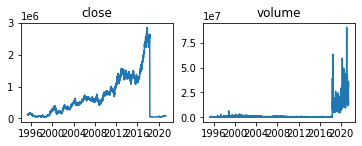

No handles with labels found to put in legend.


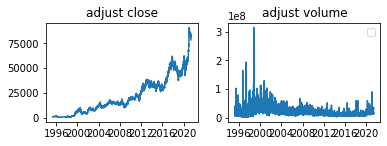

In [40]:
import matplotlib.pyplot as plt

x = samsung_data.index.get_level_values(0)
y = samsung_data['close']
plt.subplot(2,2,1)
plt.plot(x, y)
plt.title('close')

y = samsung_data['volume']
plt.subplot(2,2,2)
plt.plot(x, y)
plt.title('volume')
plt.show()

y = samsung_data['adj_close']
plt.subplot(2,2,3)
plt.plot(x, y)
plt.title('adjust close')

y = samsung_data['adj_volume']
plt.subplot(2,2,4)
plt.plot(x, y)
plt.title('adjust volume')

plt.legend()
plt.show()

## Data 저장 위치 설정

In [41]:
DATA_STORE = Path('assets.h5')

## 가격 데이터 저장

In [42]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('finance_datareader/prices', kospi_data)

## 회사 코드랑 이름 저장

In [43]:
kospi_stock = kospi[['Symbol','Name']]

In [44]:
kospi_stock.columns = ['code', 'name']

In [45]:
kospi_stock.set_index('code', inplace=True)

In [46]:
kospi_stock

,name
code,
095570,AJ네트웍스
006840,AK홀딩스
027410,BGF
282330,BGF리테일
138930,BNK금융지주
...,...
079980,휴비스
005010,휴스틸
069260,휴켐스


In [47]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('finance_datareader/stocks', kospi_stock)

## BenchMark로 설정할 KOPSI 100 데이터

In [48]:
kospi_100_price = fdr.DataReader('KS100')

In [49]:
kospi_100_price.rename(columns=str.lower, inplace=True)

In [50]:
kospi_100_price.index.names = ['date']

In [51]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('finance_datareader/kospi100', kospi_100_price)

## 코스피 회사 데이터 저장

In [52]:
kospi.rename(columns=str.lower, inplace=True)
kospi.set_index('symbol', inplace=True)

In [54]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('kospi/stocks', kospi)

C:\Users\PC\anaconda3\envs\ml4t_orginal\lib\site-packages\IPython\core\interactiveshell.py:3357: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['market', 'name', 'sector', 'industry', 'settlemonth', 'representative',
       'homepage', 'region'],
      dtype='object')]

  if (await self.run_code(code, result,  async_=asy)):
